## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("./Higher player.csv")

In [3]:
df.shape

(4840, 19)

In [4]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [5]:
df.drop(columns='Unnamed: 0' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [7]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [8]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [9]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [10]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2017
Cheap_Price    1603
High_Price     1220
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [11]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,70000000,High_Price
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,High_Price


In [12]:
categorical_col = ['team' , 'position']

In [13]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [14]:
df.shape

(4840, 367)

In [15]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])  

#### 3. Feature selection

In [16]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
highest_value          0.582366
appearance             0.494350
minutes played         0.378611
assists                0.238781
                         ...   
team_SV Ried          -0.083769
clean sheets          -0.092218
position_Goalkeeper   -0.113328
goals conceded        -0.121615
age                   -0.137774
Name: sale_price_category, Length: 367, dtype: float64

In [17]:
# Set the correlation threshold
threshold = 0.4  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['appearance', 'highest_value', 'sale_price_category'], dtype='object')

In [18]:
df = df[selected_features]

#### 4. Prepare train and test data

In [19]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# # sacle the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [20]:
X.shape

(4840, 2)

## Buliding the Model

In [21]:
model = SVC()

In [22]:
param_grid = {
    'kernel': [
             # 'linear',
               'rbf',
             # 'poly'
              ],   # Regularization strength
    'C':[0, 2, 5, 10, 15, 20, 25, 30, 35],
    'gamma': [1,2,4,6,8]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [23]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0, 2, 5, 10, 15, 20, 25, 30, 35],
                         'gamma': [1, 2, 4, 6, 8], 'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [24]:
grid_search.best_params_

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

In [25]:
model = grid_search.best_estimator_

## Test the Model

In [26]:
# Predict and evaluate the model
y_pred = model.predict(X_test)

## Evaluating the Model 

In [27]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

41.67

1. Accuracy

In [28]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train accuracy' ,accuracy_train*100)


Test accuracy 68.90495867768594
Train accuracy 89.56611570247934


2. Precision

In [29]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print(f"Test Precision: {precision_test:.2f}")

y_pred_train = model.predict(X_train)
precision_train = precision_score(y_train, y_pred_train,average='macro')
print(f"Train Precision: {precision_train:.2f}")

Test Precision: 0.73
Train Precision: 0.90


3. Recall

In [30]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print(f"Test Recall: {recall_test:.2f}")

y_pred_train = model.predict(X_train)
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Train Recall: {recall_train:.2f}")

Test Recall: 0.67
Train Recall: 0.90


4. F1 Score

In [31]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 Score: {f1_test:.2f}")

y_pred_train = model.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"Train F1 Score: {f1_train:.2f}")

Test F1 Score: 0.69
Train F1 Score: 0.90


#### Predictions vs. Real Values

In [32]:
predictions = model.predict(X_test)

In [33]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

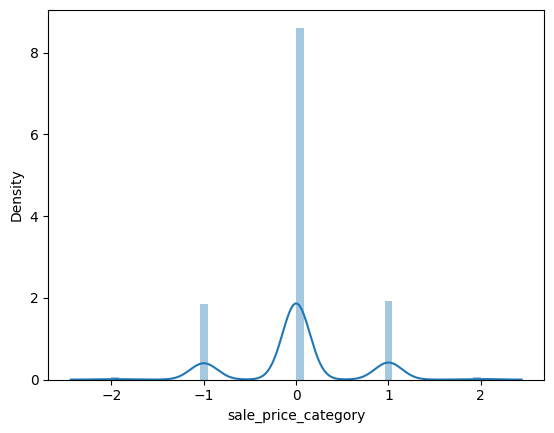

In [34]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[200, 108,   4],
       [ 50, 315,  35],
       [  5,  99, 152]], dtype=int64)